In [34]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import seaborn as sns
import re
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from textblob import TextBlob
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score, f1_score
from imblearn.over_sampling import SMOTE
import pickle

In [35]:
# Downloading necessary NLTK resources
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\sevak\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\sevak\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

Web scrape China Wikipedia page

In [36]:
def scrape_wikipedia(url):
    response = requests.get(url)
    soup = BeautifulSoup(response.content, 'html.parser')
    
    # Extract text from paragraphs in the main content
    content = soup.find('div', {'id': 'mw-content-text'})
    paragraphs = content.find_all('p')
    
    # Combine all paragraphs into one text
    text = ' '.join([p.get_text() for p in paragraphs])
    
    return text

Clean and preprocess text

In [37]:
def clean_text(text):
    # Remove references [1], [2], etc.
    text = re.sub(r'\[\d+\]', '', text)
    
    # Remove special characters and extra whitespace
    text = re.sub(r'[^\w\s.,;:!?]', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    
    return text.strip()

Tokenize sentences and analyze sentiment

In [38]:
def analyze_sentiment(text):
    sentences = sent_tokenize(text)
    
    sentiment_data = []
    
    for sentence in sentences:
        if len(sentence.strip()) > 10:  # Ignore very short segments
            analysis = TextBlob(sentence)
            polarity = analysis.sentiment.polarity
            
            # Classify sentiment
            if polarity > 0.0:
                sentiment = 'positive'
            elif polarity < 0.0:
                sentiment = 'negative'
            else:
                sentiment = 'neutral'
            
            sentiment_data.append({
                'sentence': sentence,
                'polarity': polarity,
                'sentiment': sentiment
            })
    
    return sentiment_data, sentences

Word tokenize and remove stopwords

In [39]:
def process_words(text):
    words = word_tokenize(text.lower())
    stop_words = set(stopwords.words('english'))
    filtered_words = [word for word in words if word.isalnum() and word not in stop_words]
    return filtered_words

Create wordcloud

In [40]:
def generate_wordcloud(words):
    word_freq = Counter(words)
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq)
    
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.tight_layout()
    plt.savefig('china_wordcloud.png')
    plt.close()
    
    return word_freq

Build and evaluate machine learning models

In [41]:

# Updated build_models with comparison plotting
def build_models(X_train, X_test, y_train, y_test):
    models = {
        'Logistic Regression': LogisticRegression(max_iter=1000),
        'Decision Tree': DecisionTreeClassifier(),
        'Random Forest': RandomForestClassifier(),
        'Gradient Boosting': GradientBoostingClassifier(),
        'Naive Bayes': MultinomialNB(),
        'K-Nearest Neighbors': KNeighborsClassifier()
    }
    
    results = {
        'Model': [],
        'Accuracy': [],
        'F1 Score': []
    }

    model_reports = {}

    for name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        accuracy = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average='weighted')

        results['Model'].append(name)
        results['Accuracy'].append(accuracy)
        results['F1 Score'].append(f1)

        report = classification_report(y_test, y_pred, output_dict=False)
        model_reports[name] = report

        print(f"{name}:\nAccuracy: {accuracy:.4f}\nF1 Score: {f1:.4f}")
        print(report)
        print('-' * 60)

    # Create comparison plot
    df_results = pd.DataFrame(results)
    plt.figure(figsize=(12, 6))
    sns.barplot(x='Model', y='F1 Score', data=df_results, palette='viridis')
    plt.title('Model Comparison - F1 Scores')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig('model_comparison.png')
    plt.show()

    # Find the best model
    best_idx = df_results['F1 Score'].idxmax()
    best_model_name = df_results['Model'][best_idx]
    best_model = models[best_model_name]
    
    print(f"\n✅ Best Model: {best_model_name} with F1 Score: {df_results['F1 Score'][best_idx]:.4f}")

    return best_model, df_results

In [42]:
def main():
    # Web scrape Wikipedia page of China
    url = "https://en.wikipedia.org/wiki/China"
    raw_text = scrape_wikipedia(url)
    
    # Clean Text and preprocessing
    cleaned_text = clean_text(raw_text)
    
    # Sentence tokenize and sentiment analysis
    sentiment_data, sentences = analyze_sentiment(cleaned_text)
    
    # Create a dataframe of sentences and sentiment
    df = pd.DataFrame(sentiment_data)
    print(f"Total sentences: {len(df)}")
    print(df['sentiment'].value_counts())
    
    #  Word tokenize and remove stopwords
    words = process_words(cleaned_text)
    
    #  Generate wordcloud
    word_freq = generate_wordcloud(words)
    
    # Find frequent words
    print("\n--- Most Common Words ---")
    for word, count in word_freq.most_common(30):
        print(f"{word}: {count}")
    
    # Apply TFIDF Vectorizer on sentences
    df_binary = df[df['sentiment'] != 'neutral'].copy()  #  Use only positive and negative sentiments
    
    print("\n--- After removing neutral sentiments ---")
    print(df_binary['sentiment'].value_counts())
    
    # Split into features and target
    X = df_binary['sentence']
    y = df_binary['sentiment']
    
    # Apply TF-IDF Vectorization
    tfidf_vectorizer = TfidfVectorizer(max_features=5000)
    X_tfidf = tfidf_vectorizer.fit_transform(X)
    
    # Split into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.3, random_state=42)
    
    #  Use SMOTE to balance sentiment
    smote = SMOTE(random_state=42)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
    
    print("\n--- Class distribution after SMOTE ---")
    print(pd.Series(y_train_resampled).value_counts())
    
    #  Build machine learning models
    best_model, results = build_models(X_train_resampled, X_test, y_train_resampled, y_test)
    
    # Saving the best model and vectorizer
    with open('best_model.pkl', 'wb') as f:
        pickle.dump(best_model, f)
    
    with open('tfidf_vectorizer.pkl', 'wb') as f:
        pickle.dump(tfidf_vectorizer, f)
    
    print("Best model and vectorizer saved to files.")

Total sentences: 610
sentiment
positive    265
neutral     231
negative    114
Name: count, dtype: int64

--- Most Common Words ---
china: 324
chinese: 134
world: 112
largest: 72
country: 64
million: 43
one: 42
dynasty: 41
population: 40
government: 40
state: 34
also: 32
ccp: 31
since: 30
second: 28
first: 25
people: 24
according: 24
national: 24
update: 24
2023: 23
asia: 22
three: 22
east: 21
states: 21
major: 21
total: 21
prc: 20
billion: 20
beijing: 20

--- After removing neutral sentiments ---
sentiment
positive    265
negative    114
Name: count, dtype: int64

--- Class distribution after SMOTE ---
sentiment
positive    182
negative    182
Name: count, dtype: int64
Logistic Regression:
Accuracy: 0.7632
F1 Score: 0.7352
              precision    recall  f1-score   support

    negative       0.62      0.32      0.43        31
    positive       0.79      0.93      0.85        83

    accuracy                           0.76       114
   macro avg       0.71      0.63      0.64     

c:\Users\sevak\anaconda3\Lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Random Forest:
Accuracy: 0.7368
F1 Score: 0.6799
              precision    recall  f1-score   support

    negative       0.56      0.16      0.25        31
    positive       0.75      0.95      0.84        83

    accuracy                           0.74       114
   macro avg       0.65      0.56      0.55       114
weighted avg       0.70      0.74      0.68       114

------------------------------------------------------------
Gradient Boosting:
Accuracy: 0.7368
F1 Score: 0.7273
              precision    recall  f1-score   support

    negative       0.52      0.42      0.46        31
    positive       0.80      0.86      0.83        83

    accuracy                           0.74       114
   macro avg       0.66      0.64      0.64       114
weighted avg       0.72      0.74      0.73       114

------------------------------------------------------------
Naive Bayes:
Accuracy: 0.7018
F1 Score: 0.7129
              precision    recall  f1-score   support

    negative       0

c:\Users\sevak\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\sevak\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\sevak\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sevak\AppData\Local\Temp\ipyker

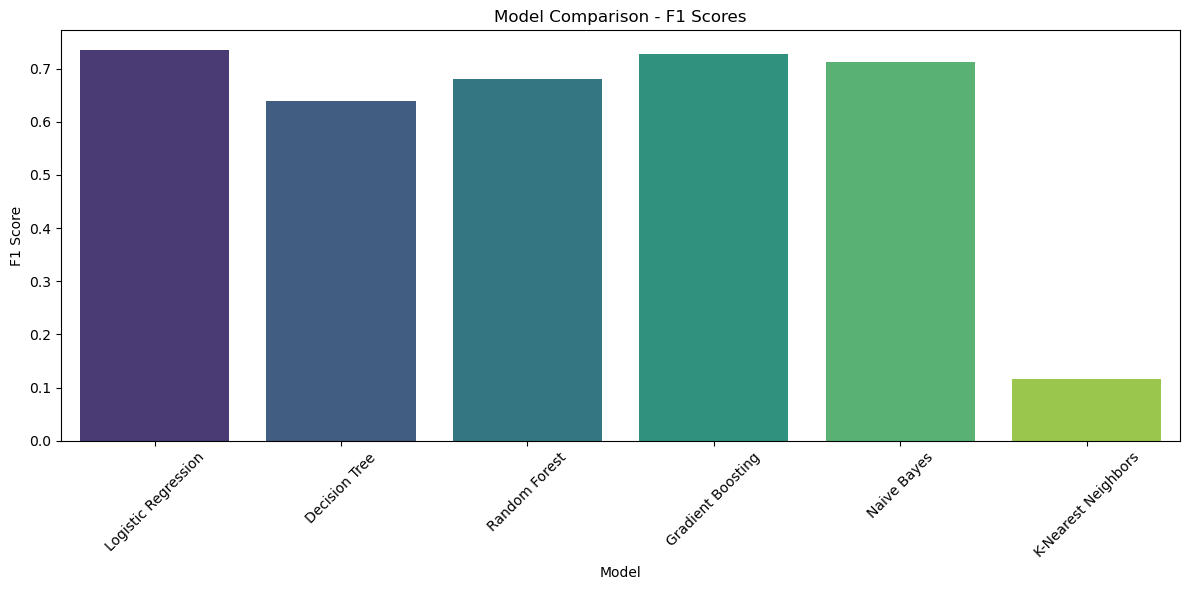


✅ Best Model: Logistic Regression with F1 Score: 0.7352
Best model and vectorizer saved to files.


In [43]:
if __name__ == "__main__":
    main()